In [43]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


In [44]:
# send the GET request
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [45]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [46]:
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []

In [47]:
# find the table
soup.find('table').find_all('tr')

# find all the rows of the table
soup.find('table').find_all('tr')

# for each row of the table, find all the table data
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')

In [48]:
# append the data into the respective lists
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text.rstrip('\n'))
        boroughList.append(cells[1].text.rstrip('\n'))
        neighborhoodList.append(cells[2].text.rstrip('\n')) # avoid new lines in neighborhood cell

In [49]:
# create a new DataFrame from the three lists
toronto_df = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [50]:
# drop cells with a borough that is Not assigned
toronto_df_dropna = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
toronto_df_dropna.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [51]:
toronto_df_grouped = toronto_df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [52]:

# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
        
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [53]:
# create a new test dataframe
column_names = ["PostalCode", "Borough", "Neighborhood"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_df_grouped[toronto_df_grouped["PostalCode"]==postcode], ignore_index=True)
    
test_df

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Parkview Hill, Woodbine Gardens"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,"Wexford, Maryvale"
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har..."


In [54]:
# print the number of rows of the cleaned dataframe
toronto_df_grouped.shape

(103, 3)

In [58]:

# load the coordinates from the csv file on Coursera
coordinates = pd.read_csv("https://cocl.us/Geospatial_data")
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [59]:
# rename the column "PostalCode"
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [60]:
# merge two table on the column "PostalCode"
toronto_df_new = toronto_df_grouped.merge(coordinates, on="PostalCode", how="left")
toronto_df_new.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [61]:
# create a new test dataframe
column_names = ["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_df_new[toronto_df_new["PostalCode"]==postcode], ignore_index=True)
    
test_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420


In [63]:
latitude=43.653963
longitude=-79.387207
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [64]:
# filter borough names that contain the word Toronto
borough_names = list(toronto_df_new.Borough.unique())

borough_with_toronto = []

for x in borough_names:
    if "toronto" in x.lower():
        borough_with_toronto.append(x)
        
borough_with_toronto

['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

In [65]:
# create a new DataFrame with only boroughs that contain the word Toronto
toronto_df_new = toronto_df_new[toronto_df_new['Borough'].isin(borough_with_toronto)].reset_index(drop=True)
print(toronto_df_new.shape)
toronto_df_new.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [66]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [67]:
# define Foursquare Credentials and Version
CLIENT_ID = 'O40DHTXH00T40LUTYMBQ3DPTEZ0VW0P3E34V30IPWYVMQV1L' # your Foursquare ID
CLIENT_SECRET = 'Z0VDZD5Y5D0MNJJR5LCGJU3KKPCRAVCJJMWLRATZAE0ZY4QA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O40DHTXH00T40LUTYMBQ3DPTEZ0VW0P3E34V30IPWYVMQV1L
CLIENT_SECRET:Z0VDZD5Y5D0MNJJR5LCGJU3KKPCRAVCJJMWLRATZAE0ZY4QA


In [74]:
test_df.loc[0, 'Borough']

'Downtown Toronto'

In [76]:
print('Latitude and longitude values of {} are {}, {}.'.format(test_df.loc[0, 'Borough'], 
                                                               test_df.loc[0, 'Latitude'], 
                                                               test_df.loc[0, 'Longitude']))

Latitude and longitude values of Downtown Toronto are 43.6579524, -79.3873826.


In [77]:
params = dict(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  v=VERSION,
  ll=f"{test_df.loc[0, 'Latitude']}, {test_df.loc[0, 'Longitude']}",
  radius=500,
  limit=100
)

In [80]:
search_url = 'https://api.foursquare.com/v2/venues/search'
resp = requests.get(url=search_url, params=params)
data = resp.json()

In [81]:
data['response']['venues'][0]

{'id': '4ad4c064f964a52070f820e3',
 'name': 'Toronto General Hospital',
 'location': {'address': '190 Elizabeth St',
  'crossStreet': 'at Gerrard St W',
  'lat': 43.658762182159144,
  'lng': -79.38829248908566,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.658762182159144,
    'lng': -79.38829248908566}],
  'distance': 116,
  'postalCode': 'M5G 2C4',
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['190 Elizabeth St (at Gerrard St W)',
   'Toronto ON M5G 2C4',
   'Canada']},
 'categories': [{'id': '4bf58dd8d48988d196941735',
   'name': 'Hospital',
   'pluralName': 'Hospitals',
   'shortName': 'Hospital',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1594162160',
 'hasPerk': False}

In [82]:
def get_venues(neighborhood, lat, long, limit=100, radius=250):
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        ll=f"{lat}, {long}",
        radius=radius,
        limit=limit
    )
    venues = []
    data = requests.get(url=search_url, params=params).json()
    for v in data['response']['venues']:
        venues.append([neighborhood, lat, long, v['name'], v['location']['lat'], v['location']['lng'], 
                       ', '.join(x['name'] for x in v['categories'])])
    return venues

In [83]:
nbr_venues_df = pd.DataFrame()
columns=['Neighborhood', 'NeighborhoodLat', 'NeighborhoodLong', 'VenueName', 'VenueLat', 'VenueLong', 'VenueCategory']

In [84]:
for name, lat, long in zip(test_df.Neighborhood, test_df.Latitude, test_df.Longitude):
    nbr_venues_df = nbr_venues_df.append(get_venues(name, lat, long))

In [85]:
nbr_venues_df.columns = columns

In [86]:
nbr_venues_df.head()

,Neighborhood,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,Central Bay Street,43.657952,-79.387383,Toronto General Hospital,43.658762,-79.388292,Hospital
1,Central Bay Street,43.657952,-79.387383,Lettieri Espresso Bar + Cafe,43.659185,-79.387264,Café
2,Central Bay Street,43.657952,-79.387383,Toronto General Hospital Emergency Room,43.658426,-79.386462,Emergency Room
3,Central Bay Street,43.657952,-79.387383,The Hospital for Sick Children (SickKids),43.657499,-79.386512,Hospital
4,Central Bay Street,43.657952,-79.387383,Toronto General Hospital Parking Lot,43.659780,-79.385699,Auto Garage


In [87]:
nbr_venues_df.shape

(1162, 7)

In [88]:
nbr_venues_df.to_csv('toronto_boroughs_and_venues.csv')

In [89]:
nbr_venues_df = pd.read_csv('toronto_boroughs_and_venues.csv')
nbr_venues_df.drop(['Unnamed: 0'], axis=1, inplace=True)
nbr_venues_df.head()

,Neighborhood,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,Central Bay Street,43.657952,-79.387383,Toronto General Hospital,43.658762,-79.388292,Hospital
1,Central Bay Street,43.657952,-79.387383,Lettieri Espresso Bar + Cafe,43.659185,-79.387264,Café
2,Central Bay Street,43.657952,-79.387383,Toronto General Hospital Emergency Room,43.658426,-79.386462,Emergency Room
3,Central Bay Street,43.657952,-79.387383,The Hospital for Sick Children (SickKids),43.657499,-79.386512,Hospital
4,Central Bay Street,43.657952,-79.387383,Toronto General Hospital Parking Lot,43.659780,-79.385699,Auto Garage


In [90]:
nbr_venues_df.VenueCategory.replace('', np.nan, inplace=True)
nbr_venues_df.dropna(inplace=True)
nbr_venues_df.shape

(1057, 7)

In [91]:
nbr_venues_df.VenueCategory.value_counts()

Automotive Shop                             41
Coffee Shop                                 30
Salon / Barbershop                          30
Pizza Place                                 25
Hospital                                    22
Office                                      22
Medical Center                              21
Building                                    21
Bank                                        19
Church                                      18
Gas Station                                 17
Residential Building (Apartment / Condo)    17
Dentist's Office                            17
Pharmacy                                    16
Furniture / Home Store                      15
Bakery                                      14
Movie Theater                               14
Sandwich Place                              14
Park                                        13
Convenience Store                           13
Moving Target                               12
Airport Gate 

In [92]:
# Dropping rows i.e categories which are mentioned less than 15 times in the dataset
common_categories = nbr_venues_df.VenueCategory.unique()[nbr_venues_df.VenueCategory.value_counts()>15]

In [93]:

nbr_venues_df = nbr_venues_df[nbr_venues_df.VenueCategory.isin(common_categories)]
nbr_venues_df.shape

(149, 7)

In [94]:
from IPython.core.display import HTML

display(HTML(nbr_venues_df.groupby('Neighborhood').count().to_html()))

,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
Neighborhood,,,,,,
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",2,2,2,2,2,2
Central Bay Street,48,48,48,48,48,48
Hillcrest Village,11,11,11,11,11,11
Humber Summit,5,5,5,5,5,5
Leaside,10,10,10,10,10,10
"Malvern, Rouge",11,11,11,11,11,11
"Parkview Hill, Woodbine Gardens",11,11,11,11,11,11
"Regent Park, Harbourfront",7,7,7,7,7,7
Scarborough Village,7,7,7,7,7,7


In [95]:
nbr_venues_df.groupby('Neighborhood').count().VenueCategory.min()

2

In [96]:

# add neighborhood column back to dataframe
category_onehot = pd.get_dummies(nbr_venues_df.VenueCategory)
category_onehot['Neighborhood'] = nbr_venues_df.Neighborhood

# move neighborhood column to the first column
fixed_columns = [category_onehot.columns[-1]] + list(category_onehot.columns[:-1])
category_onehot = category_onehot[fixed_columns]

In [97]:
category_onehot.head()

,Neighborhood,Auto Garage,Burger Joint,Bus Line,Café,Clothing Store,Coffee Shop,Deli / Bodega,Emergency Room,Hospital,Medical Center,Metro Station,Pharmacy,Sandwich Place,Smoothie Shop
0,Central Bay Street,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Central Bay Street,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Central Bay Street,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Central Bay Street,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Central Bay Street,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
category_onehot.shape

(149, 15)

In [99]:
category_onehot = category_onehot.groupby('Neighborhood').mean().reset_index()
category_onehot

,Neighborhood,Auto Garage,Burger Joint,Bus Line,Café,Clothing Store,Coffee Shop,Deli / Bodega,Emergency Room,Hospital,Medical Center,Metro Station,Pharmacy,Sandwich Place,Smoothie Shop
0,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Central Bay Street,0.020833,0.020833,0.020833,0.041667,0.020833,0.104167,0.041667,0.0625,0.437500,0.104167,0.020833,0.062500,0.020833,0.020833
2,Hillcrest Village,0.000000,0.000000,0.272727,0.000000,0.000000,0.181818,0.000000,0.0000,0.000000,0.272727,0.000000,0.181818,0.090909,0.000000
3,Humber Summit,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0000,0.000000,0.200000,0.000000,0.200000,0.200000,0.000000
4,Leaside,0.100000,0.100000,0.000000,0.000000,0.100000,0.300000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.300000,0.100000
5,"Malvern, Rouge",0.090909,0.000000,0.000000,0.000000,0.000000,0.272727,0.000000,0.0000,0.000000,0.272727,0.000000,0.181818,0.181818,0.000000
6,"Parkview Hill, Woodbine Gardens",0.000000,0.000000,0.181818,0.272727,0.000000,0.181818,0.000000,0.0000,0.000000,0.090909,0.000000,0.090909,0.181818,0.000000
7,"Regent Park, Harbourfront",0.000000,0.000000,0.000000,0.142857,0.000000,0.428571,0.000000,0.0000,0.142857,0.142857,0.000000,0.000000,0.142857,0.000000
8,Scarborough Village,0.000000,0.285714,0.285714,0.000000,0.000000,0.285714,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
9,"South Steeles, Silverstone, Humbergate, Jamest...",0.000000,0.000000,0.076923,0.000000,0.307692,0.076923,0.000000,0.0000,0.000000,0.307692,0.000000,0.230769,0.000000,0.000000


In [100]:
num_top_venues = 5

for nbrhood in category_onehot['Neighborhood']:
    print("---- "+nbrhood+" ----")
    temp = category_onehot[category_onehot['Neighborhood'] == nbrhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport ----
          venue  freq
0   Coffee Shop   1.0
1   Auto Garage   0.0
2  Burger Joint   0.0
3      Bus Line   0.0
4          Café   0.0


---- Central Bay Street ----
            venue  freq
0        Hospital  0.44
1     Coffee Shop  0.10
2  Medical Center  0.10
3  Emergency Room  0.06
4        Pharmacy  0.06


---- Hillcrest Village ----
            venue  freq
0        Bus Line  0.27
1  Medical Center  0.27
2     Coffee Shop  0.18
3        Pharmacy  0.18
4  Sandwich Place  0.09


---- Humber Summit ----
            venue  freq
0     Auto Garage   0.2
1  Clothing Store   0.2
2  Medical Center   0.2
3        Pharmacy   0.2
4  Sandwich Place   0.2


---- Leaside ----
            venue  freq
0     Coffee Shop   0.3
1  Sandwich Place   0.3
2     Auto Garage   0.1
3    Burger Joint   0.1
4  Clothing Store   0.1


---- Malvern, Rouge ----
            venue  freq
0     Coffee Shop

In [102]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [103]:

indicators = ['st', 'nd', 'rd']
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nbr_venues_sorted_df = pd.DataFrame(columns=columns)
nbr_venues_sorted_df['Neighborhood'] = category_onehot['Neighborhood']

for ind in np.arange(category_onehot.shape[0]):
    nbr_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(category_onehot.iloc[ind, :], num_top_venues)

nbr_venues_sorted_df.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Smoothie Shop,Sandwich Place,Pharmacy,Metro Station,Medical Center,Hospital,Emergency Room,Deli / Bodega,Clothing Store
1,Central Bay Street,Hospital,Medical Center,Coffee Shop,Pharmacy,Emergency Room,Deli / Bodega,Café,Smoothie Shop,Sandwich Place,Metro Station
2,Hillcrest Village,Medical Center,Bus Line,Pharmacy,Coffee Shop,Sandwich Place,Smoothie Shop,Metro Station,Hospital,Emergency Room,Deli / Bodega
3,Humber Summit,Sandwich Place,Pharmacy,Medical Center,Clothing Store,Auto Garage,Smoothie Shop,Metro Station,Hospital,Emergency Room,Deli / Bodega
4,Leaside,Sandwich Place,Coffee Shop,Smoothie Shop,Clothing Store,Burger Joint,Auto Garage,Pharmacy,Metro Station,Medical Center,Hospital


In [104]:
from sklearn.cluster import KMeans

In [105]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)

In [106]:
X = category_onehot.drop(['Neighborhood'], axis=1)
X.head()

,Auto Garage,Burger Joint,Bus Line,Café,Clothing Store,Coffee Shop,Deli / Bodega,Emergency Room,Hospital,Medical Center,Metro Station,Pharmacy,Sandwich Place,Smoothie Shop
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.020833,0.020833,0.020833,0.041667,0.020833,0.104167,0.041667,0.0625,0.4375,0.104167,0.020833,0.062500,0.020833,0.020833
2,0.000000,0.000000,0.272727,0.000000,0.000000,0.181818,0.000000,0.0000,0.0000,0.272727,0.000000,0.181818,0.090909,0.000000
3,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0000,0.0000,0.200000,0.000000,0.200000,0.200000,0.000000
4,0.100000,0.100000,0.000000,0.000000,0.100000,0.300000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.300000,0.100000


In [107]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([1, 2, 0, 0, 2, 0, 2, 2, 2, 0], dtype=int32)

In [110]:

def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [121]:
scores = [get_inertia(x) for x in range(2, 13)]

Text(0, 0.5, 'Error')

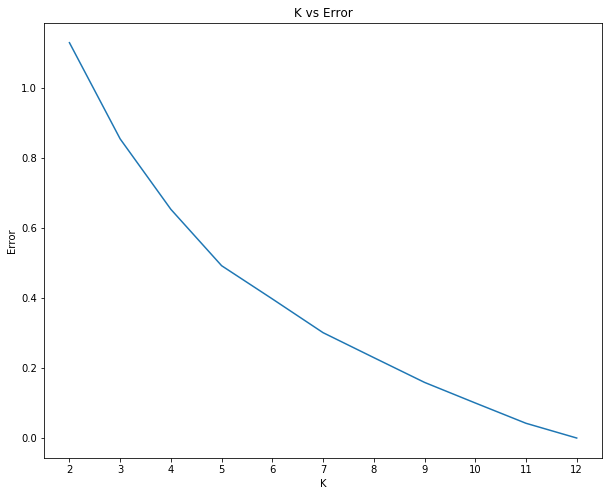

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 13), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 13))
plt.xlabel("K")
plt.ylabel("Error")

In [124]:
# train final model with k=9
kmeans = KMeans(n_clusters=9)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [125]:
kmeans.labels_[:10]

array([1, 3, 0, 4, 6, 0, 5, 8, 2, 4], dtype=int32)

In [126]:
# add clustering labels
nbr_venues_sorted_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [128]:
toronto_nbr_df = test_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_nbr_df = toronto_nbr_df.join(nbr_venues_sorted_df.set_index('Neighborhood'), on='Neighborhood')

toronto_nbr_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,Hospital,Medical Center,Coffee Shop,Pharmacy,Emergency Room,Deli / Bodega,Café,Smoothie Shop,Sandwich Place,Metro Station
1,M2H,North York,Hillcrest Village,43.803762,-79.363452,0,Medical Center,Bus Line,Pharmacy,Coffee Shop,Sandwich Place,Smoothie Shop,Metro Station,Hospital,Emergency Room,Deli / Bodega
2,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,5,Café,Sandwich Place,Coffee Shop,Bus Line,Pharmacy,Medical Center,Smoothie Shop,Metro Station,Hospital,Emergency Room
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,2,Coffee Shop,Bus Line,Burger Joint,Sandwich Place,Smoothie Shop,Pharmacy,Metro Station,Medical Center,Hospital,Emergency Room
4,M4G,East York,Leaside,43.709060,-79.363452,6,Sandwich Place,Coffee Shop,Smoothie Shop,Clothing Store,Burger Joint,Auto Garage,Pharmacy,Metro Station,Medical Center,Hospital


In [131]:
# create map
toronto_latlong = [43.653225, -79.383186]
map_clusters = folium.Map(location=toronto_latlong, zoom_start=11)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_nbr_df['Latitude'], toronto_nbr_df['Longitude'], toronto_nbr_df['Neighborhood'], toronto_nbr_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [133]:
HTML(test_df._repr_html_())

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420
